In [1]:
# Import necessary libraries
import os
import warnings
#import glob

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Audio

2024-05-27 00:10:39.894383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 00:10:39.894484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 00:10:40.016097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Ignore warnings for a cleaner output
warnings.filterwarnings("ignore")
# Set the plotting style
plt.style.use("Solarize_Light2")
# Get the default color cycle for plots
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

The MIMII dataset can be downloaded from [this website](https://zenodo.org/record/3384388). 
The dataset includes sounds from various types of industrial machinery (valve, pump, fan and slide rail). 
In this modeling, I will only focus on the fans. These files are approximately 14 GB if uncompressed.

For this example, let's assume you've uploaded the MIMII dataset to your Kaggle dataset and have it connected to your notebook.
Replace 'your-kaggle-username/mimii-dataset' with your Kaggle username and dataset name.
dataset_path = '/kaggle/input/your-kaggle-username/mimii-dataset'

# Exploratory Data Analysis
The recording file for each mechanical equipment contains a total of 8 channels, 
one for each microphone used to record sound. 
The rest of this experiment focuses on what was recorded with the first microphone. 
Let's do an EDA by selecting a pair of normal and anomalous 10-second sound wave files.

File: /kaggle/input/dcase-aml/dev_data/dev_data/slider/test/normal_id_00_00000000.wav
  Signal shape: (220500,)
  Sampling rate: 22050 Hz
  Duration: 10.00 seconds

File: /kaggle/input/dcase-aml/dev_data/dev_data/slider/test/anomaly_id_00_00000000.wav
  Signal shape: (220500,)
  Sampling rate: 22050 Hz
  Duration: 10.00 seconds



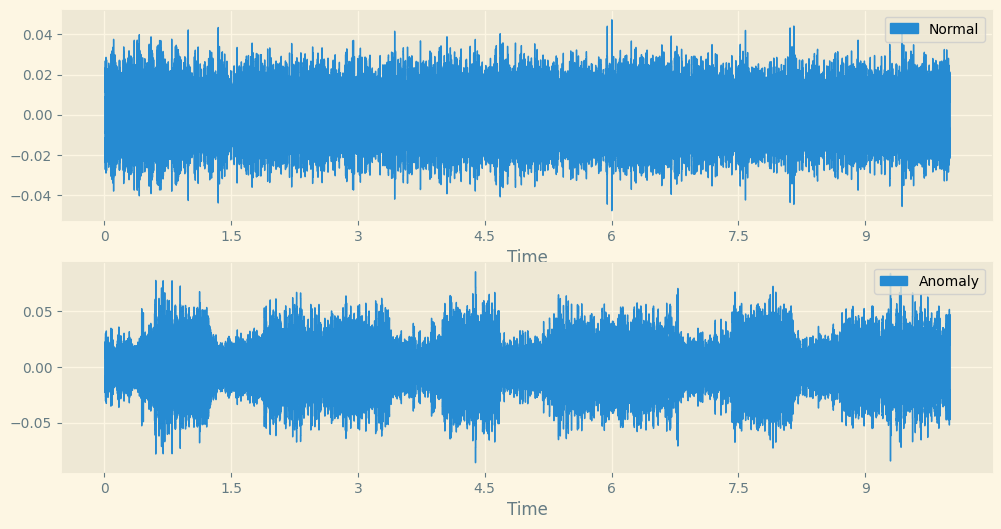

In [3]:
# Kaggle dataset path (adjust if needed)
dataset_path = '/kaggle/input/dcase-aml/dev_data/dev_data/slider/test'

# Define file names
normal_file = os.path.join(dataset_path, 'normal_id_00_00000000.wav')
anomalous_file = os.path.join(dataset_path, 'anomaly_id_00_00000000.wav')

# Function to load a sound file and print its information
def load_and_print_info(file_path):
    try:
        signal, sr = librosa.load(file_path)
        print(f"File: {file_path}")
        print(f"  Signal shape: {signal.shape}")
        print(f"  Sampling rate: {sr} Hz")
        print(f"  Duration: {len(signal) / sr:.2f} seconds\n")
        return signal, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Load the sound files
normal_signal, sr = load_and_print_info(normal_file)
anomalous_signal, sr = load_and_print_info(anomalous_file)

# Further analysis (example: plotting waveforms)
if normal_signal is not None and anomalous_signal is not None:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(normal_signal, sr=sr, label='Normal')
    plt.legend()

    plt.subplot(2, 1, 2)
    librosa.display.waveshow(anomalous_signal, sr=sr, label='Anomaly')
    plt.legend()
    
    plt.show()

In [4]:
# Play the normal audio
Audio(normal_file, rate=sr)

In [5]:
# Play the anomalous audio
Audio(anomalous_file, rate=sr)

### Wave Forms

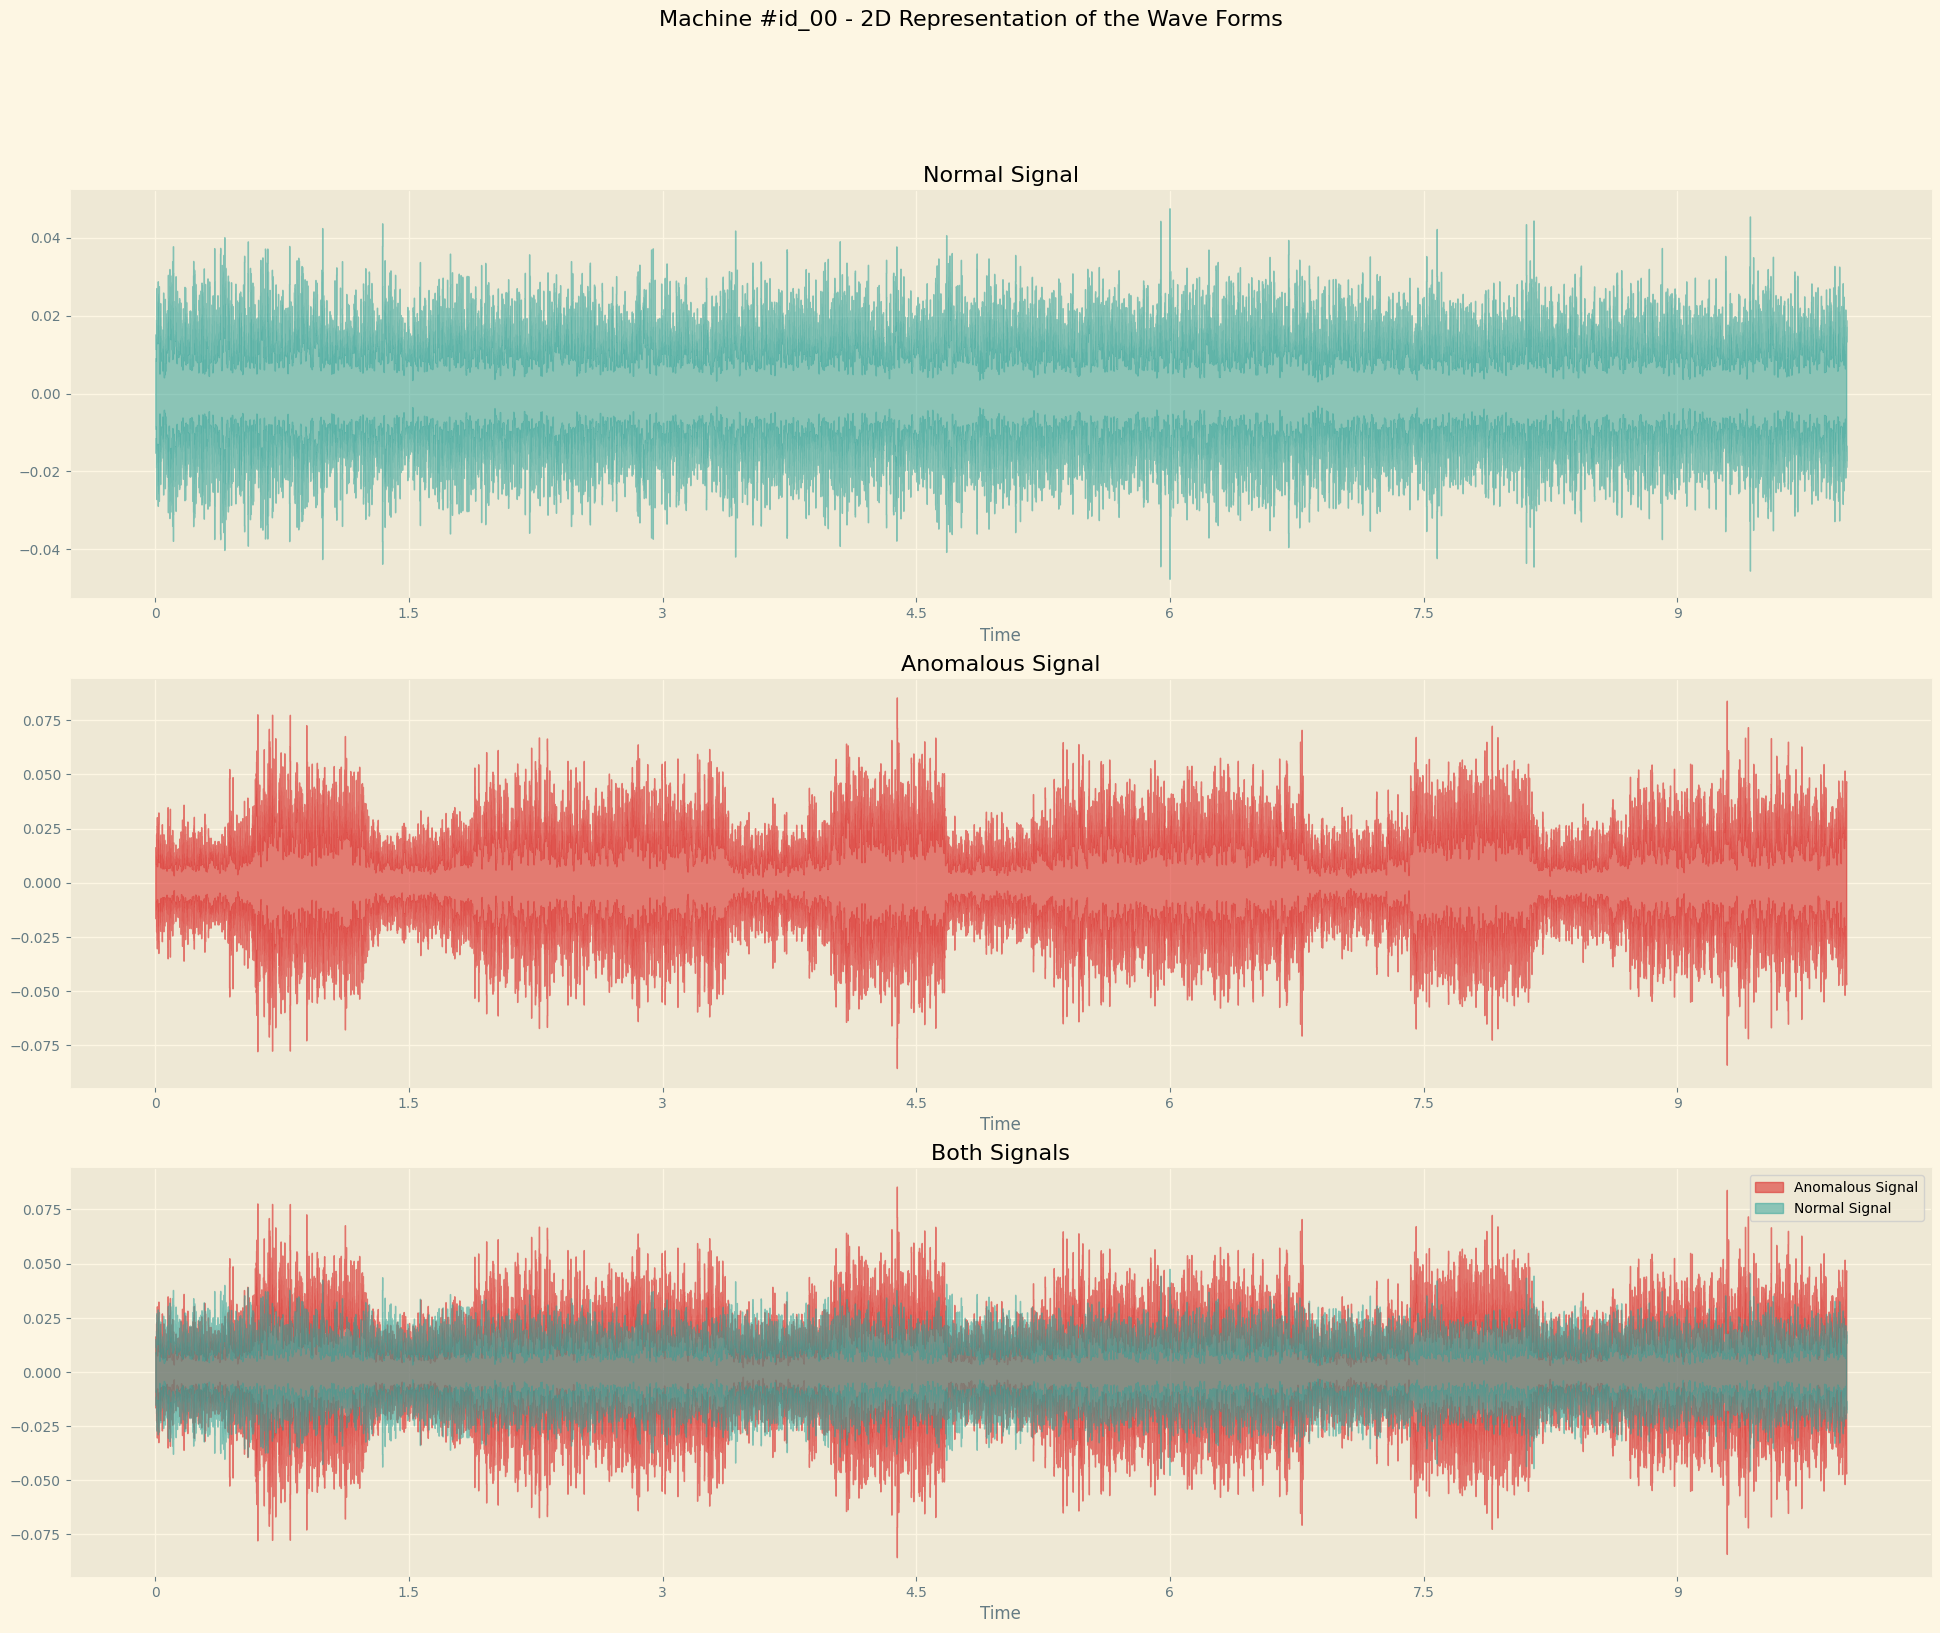

In [6]:
# Plot the waveforms
fig, axs = plt.subplots(3, 1, figsize=(24, 18))

librosa.display.waveshow(normal_signal, sr=sr, alpha=0.5, color=colors[1], ax=axs[0])
axs[0].set_title("Normal Signal")

librosa.display.waveshow(anomalous_signal, sr=sr, alpha=0.6, color=colors[5], ax=axs[1])
axs[1].set_title("Anomalous Signal")

librosa.display.waveshow(anomalous_signal, sr=sr, alpha=0.6, color=colors[5], ax=axs[2], label='Anomalous Signal')
librosa.display.waveshow(normal_signal, sr=sr, alpha=0.5, color=colors[1], ax=axs[2], label='Normal Signal')
axs[2].set_title("Both Signals")

fig.suptitle("Machine #id_00 - 2D Representation of the Wave Forms", fontsize=16)
plt.legend()
plt.show()
# fig.savefig(os.path.join(IMAGE_PATH, "wave_forms.svg"), format="svg") # Uncomment if you want to save the figure

### Short Time Fourier Tranform

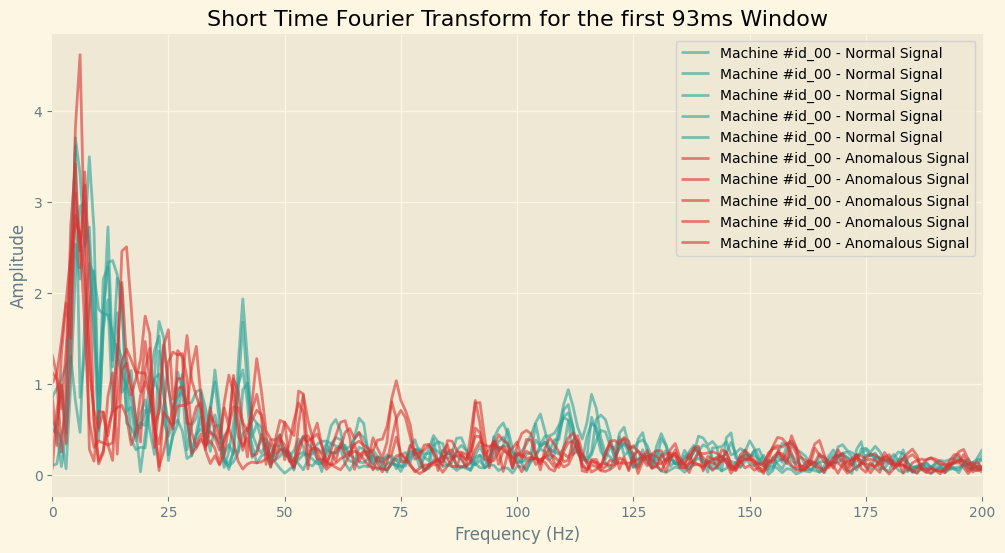

In [7]:
# Compute the Short-Time Fourier Transform (STFT)
n_fft = 2048
hop_length = 512  # Adjust hop length for desired time resolution
normal_stft = np.abs(librosa.stft(normal_signal[:n_fft], n_fft=n_fft, hop_length=hop_length))
anomalous_stft = np.abs(librosa.stft(anomalous_signal[:n_fft], n_fft=n_fft, hop_length=hop_length))

# Plot the STFT
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(normal_stft, color=colors[1], alpha=0.6, label="Machine #id_00 - Normal Signal")
ax.plot(anomalous_stft, color=colors[5], alpha=0.6, label="Machine #id_00 - Anomalous Signal")
ax.set_title(f"Short Time Fourier Transform for the first {n_fft / sr * 1000:.0f}ms Window")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
plt.legend()
plt.xlim(0, 200)
plt.show()
# fig.savefig(os.path.join(IMAGE_PATH, "stft.svg"), format="svg") # Uncomment if you want to save the figure

### Spectrograms (dB scale)

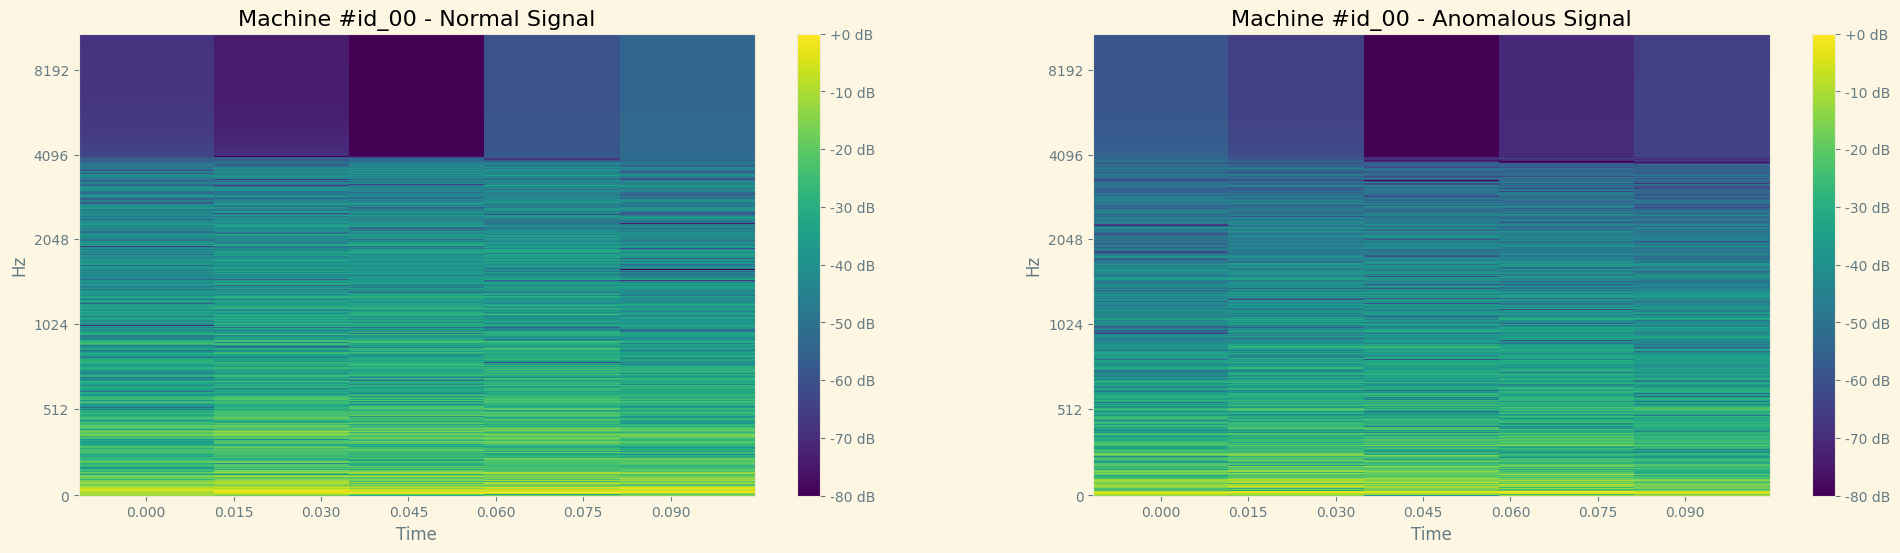

The spectrograms have a (1025, 5) shape.


In [8]:
# Compute spectrograms
normal_spectrogram = librosa.amplitude_to_db(normal_stft, ref=np.max)
anomalous_spectrogram = librosa.amplitude_to_db(anomalous_stft, ref=np.max)

# Plot the spectrograms
fig, axs = plt.subplots(1, 2, figsize=(24, 6))

img = librosa.display.specshow(normal_spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0])
axs[0].set_title("Machine #id_00 - Normal Signal")
fig.colorbar(img, ax=axs[0], format='%+2.f dB')

img = librosa.display.specshow(anomalous_spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1])
axs[1].set_title("Machine #id_00 - Anomalous Signal")
fig.colorbar(img, ax=axs[1], format='%+2.f dB')

plt.show()
# fig.savefig(os.path.join(IMAGE_PATH, "spectrograms.svg"), format="svg") # Uncomment if you want to save the figure

print(f"The spectrograms have a {normal_spectrogram.shape} shape.")

### Mel-Spectrograms

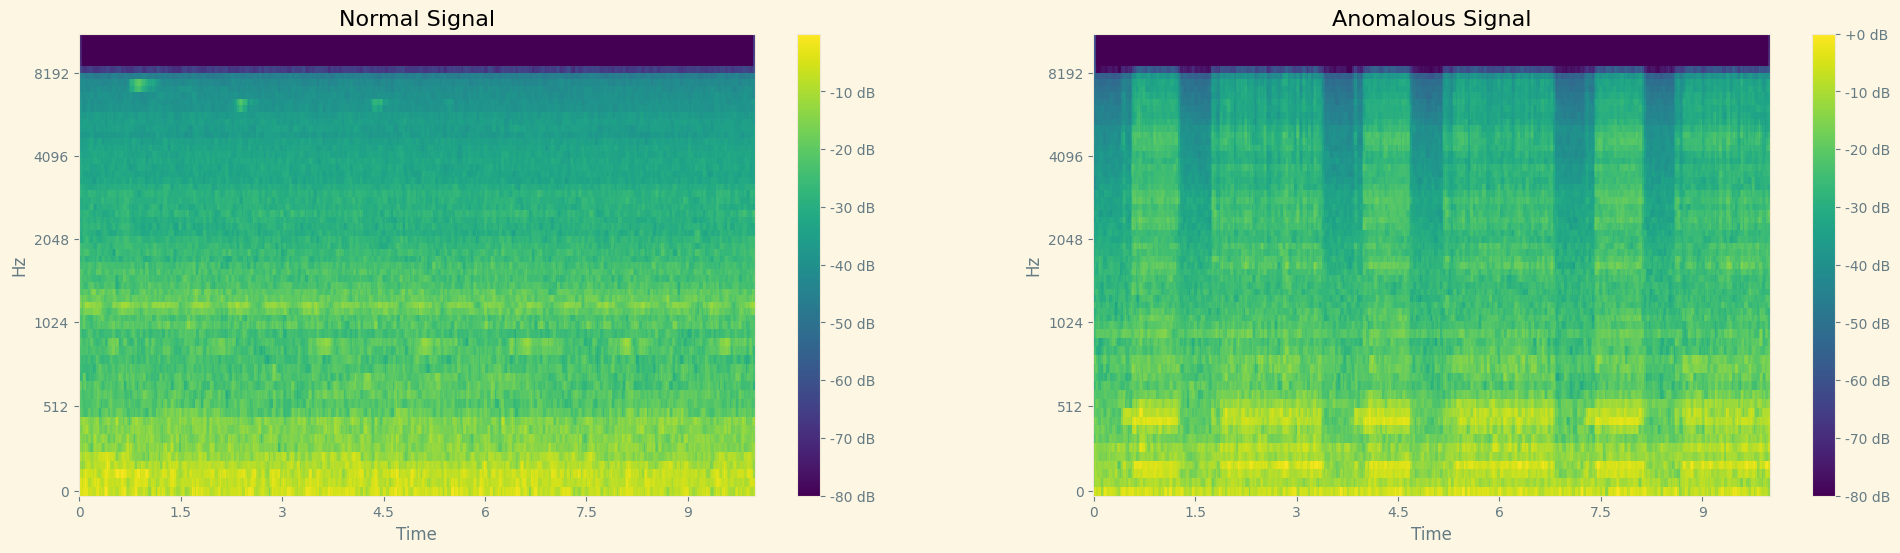

In [9]:
# Compute Mel-spectrograms
n_mels = 64
n_fft = 2048  # Window size for STFT (you might need to adjust this)
hop_length = 512 # Hop length for STFT (you might need to adjust this)

normal_mel_spectrogram = librosa.feature.melspectrogram(
    y=normal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
normal_mel_spectrogram = librosa.power_to_db(normal_mel_spectrogram, ref=np.max)

anomalous_mel_spectrogram = librosa.feature.melspectrogram(
    y=anomalous_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
anomalous_mel_spectrogram = librosa.power_to_db(anomalous_mel_spectrogram, ref=np.max)

# Plot the Mel-spectrograms
fig, axs = plt.subplots(1, 2, figsize=(24, 6))

img = librosa.display.specshow(normal_mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0])
axs[0].set_title("Normal Signal")
fig.colorbar(img, ax=axs[0], format='%+2.0f dB')

img = librosa.display.specshow(anomalous_mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1])
axs[1].set_title("Anomalous Signal")
fig.colorbar(img, ax=axs[1], format='%+2.0f dB')

plt.show() 

### Multiple Frames of Spectrograms

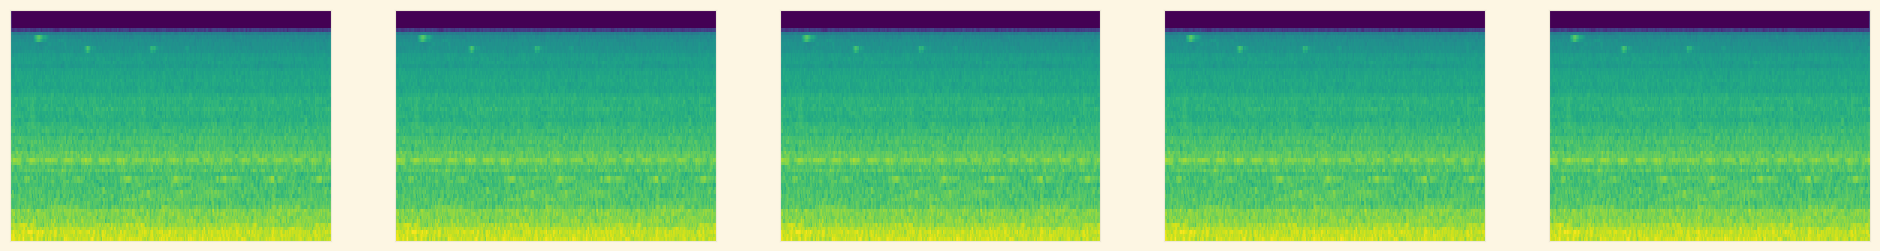

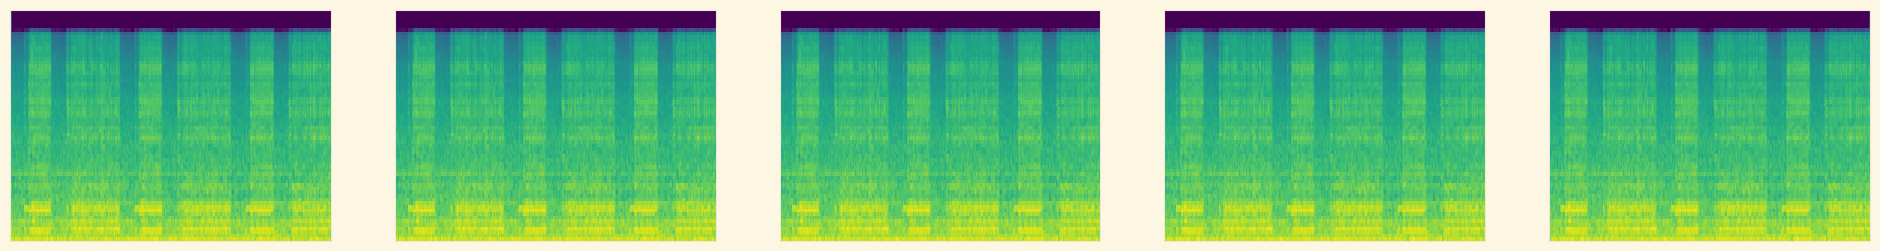

The features have a (427, 320) shape.


In [10]:
# Create and visualize multiple frames from spectrograms
frames = 5
dims = frames * n_mels

features_vector_size = normal_mel_spectrogram.shape[1] - frames + 1
normal_features = np.zeros((features_vector_size, dims), np.float32)
for t in range(frames):
    normal_features[:, n_mels * t : n_mels * (t + 1)] = normal_mel_spectrogram[:, t : t + features_vector_size].T

fig, axs = plt.subplots(1, frames, figsize=(24, 3))
for t in range(frames):
    img = librosa.display.specshow(normal_features[:, n_mels * t : n_mels * (t + 1)].T, sr=sr, hop_length=hop_length, cmap='viridis', ax=axs[t])
# fig.savefig(os.path.join(IMAGE_PATH, "normal_frames.svg"), format="svg") # Uncomment if you want to save the figure

features_vector_size = anomalous_mel_spectrogram.shape[1] - frames + 1
anomalous_features = np.zeros((features_vector_size, dims), np.float32)
for t in range(frames):
    anomalous_features[:, n_mels * t : n_mels * (t + 1)] = anomalous_mel_spectrogram[:, t : t + features_vector_size].T

fig, axs = plt.subplots(1, frames, figsize=(24, 3))
for t in range(frames):
    img = librosa.display.specshow(anomalous_features[:, n_mels * t : n_mels * (t + 1)].T, sr=sr, hop_length=hop_length, cmap='viridis', ax=axs[t])

plt.show()
# fig.savefig(os.path.join(IMAGE_PATH, "anomalous_frames.svg"), format="svg") # Uncomment if you want to save the figure

print(f"The features have a {normal_features.shape} shape.")